In [189]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
from pathlib import Path
import json
from dictor import dictor
from pprint import pprint

# specify the folder path
folder_path = Path("local_replay_jsons/")

# get a list of all files in the folder
file_list = folder_path.glob("*.json")

# sort the list based on last modified time
file_list = sorted(file_list, key=lambda x: x.stat().st_mtime)

# print the list of files in order of last modified time
for file in file_list:
    print(file.name)

file_to_view = file_list[-1]
print(f"\nWill be viewing:\n\t{file_to_view}")

with open(file_to_view, "r") as f:
    full_replay = json.load(f)

seed = dictor(full_replay, "default_seed")
my_team = "player_0"
print(f"seed = {seed}\nmy team = {my_team}")

replay_1.json
replay_2.json
replay_3.json
replay_4.json
replay_5.json
replay_6.json
replay_7.json
replay_8.json
replay_9.json
replay_10.json
replay_11.json
replay_12.json
replay_13.json

Will be viewing:
	local_replay_jsons\replay_13.json
seed = 45342
my team = player_0


In [191]:
import logging
from agent import Agent
from util import show_env, MyReplayEnv
from config import update_logging_level

In [192]:
myenv = MyReplayEnv(seed=seed, Agent=Agent, replay_json=full_replay)

{'player_0': {'faction': 'TheBuilders', 'bid': 0}, 'player_1': {'faction': 'TheBuilders', 'bid': 0}}
{'player_0': {'spawn': (6, 8), 'metal': 150, 'water': 150}, 'player_1': {}}
{'player_0': {}, 'player_1': {'spawn': array([12,  3]), 'metal': 150, 'water': 150}}
{'player_0': {'spawn': (32, 38), 'metal': 150, 'water': 150}, 'player_1': {}}
{'player_0': {}, 'player_1': {'spawn': array([34, 33]), 'metal': 150, 'water': 150}}
{'player_0': {'spawn': (30, 30), 'metal': 150, 'water': 150}, 'player_1': {}}
{'player_0': {}, 'player_1': {'spawn': array([36, 26]), 'metal': 150, 'water': 150}}


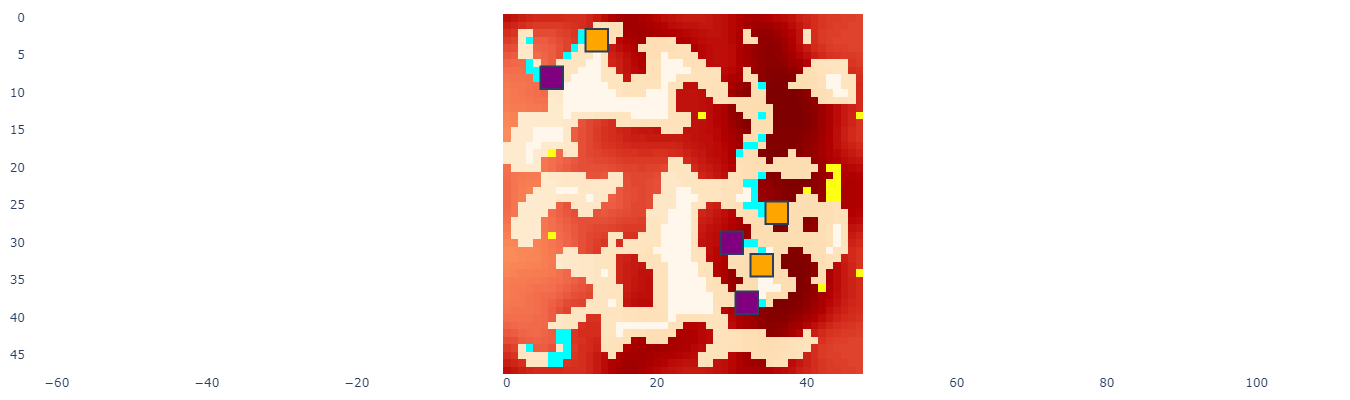

In [197]:
# Clear logfile
with open("logfile.log", "w") as f:
    pass
myenv.run_early_setup()
myenv.show()

  0%|          | 0/10 [00:00<?, ?it/s]

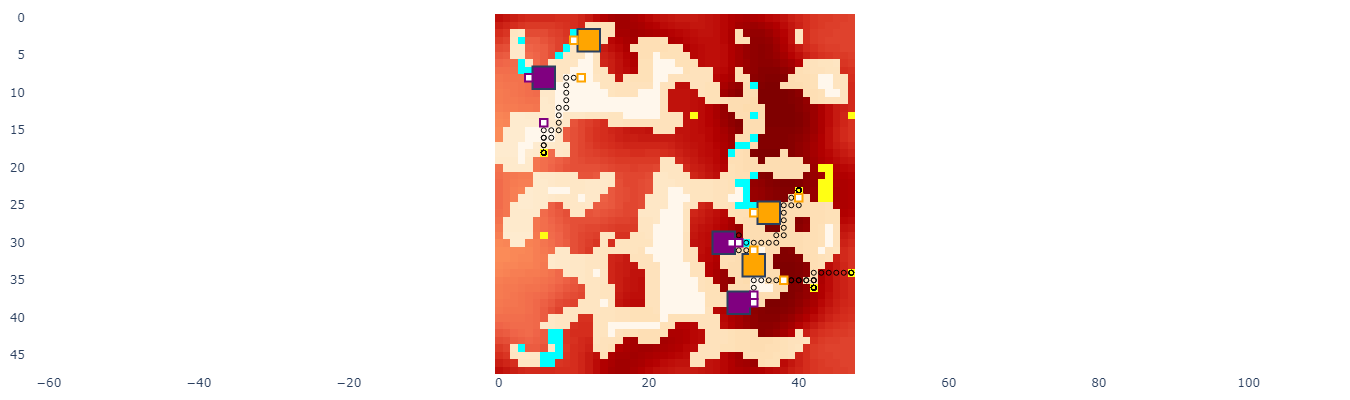

In [198]:
myenv.run_to_step(10)
# myenv.step()
myenv.show()

## Run one step at a time

In [200]:
import numpy as np
from unit_manager import FriendlyUnitManger
from unit_action_planner import UnitPaths
import util

In [201]:
agent = myenv.agent

In [202]:
paths = UnitPaths.from_units(
    friendly=agent.master.units.friendly.all,
    enemy=agent.master.units.enemy.all,
    friendly_valid_move_map=agent.master.maps.valid_friendly_move,
    enemy_valid_move_map=agent.master.maps.valid_enemy_move,
)

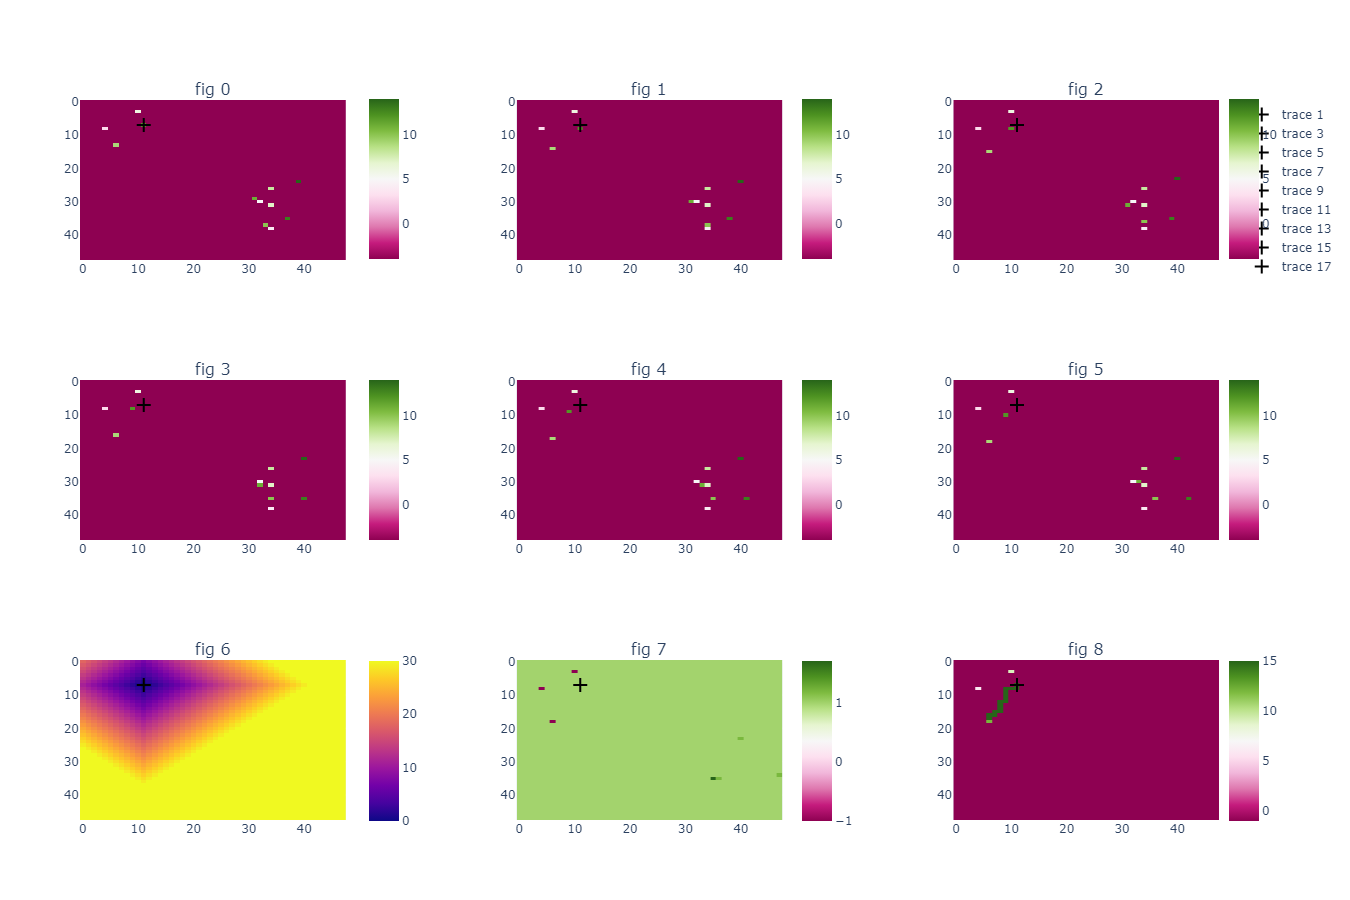

In [218]:
import plotly.graph_objects as go

start_step = 0
pos = (11, 7)
# pos = (35, 32)

figs = []
for i in range(6):
    fig = util.show_map_array(paths.all[i])
    figs.append(fig)

# Distance kernel
kernel = util.manhattan_kernel(paths.max_step - start_step)
kernel[kernel > paths.max_step] = paths.max_step
index_array = util.pad_and_crop(
    kernel,
    paths.friendly_valid_move_map,
    pos[0],
    pos[1],
    fill_value=paths.max_step - start_step,
)
figs.append(util.show_map_array(index_array))

# Calulated paths
cm = paths.to_costmap(
    pos=pos,
    start_step=start_step,
    # Add id_num here to exclude from costmap
    exclude_id_nums=[],
    friendly_light=True,
    friendly_heavy=True,
    enemy_light=True,
    enemy_heavy=True,
    collision_cost_value=-1,
    nearby_start_cost=5,
    nearby_dropoff_multiplier=0.7,
)
figs.append(util.show_map_array(cm))

collision_unit_ids = paths.calculate_likely_unit_collisions(
    pos=pos,
    start_step=start_step,
    exclude_id_nums=[],
    friendly_light=True,
    friendly_heavy=True,
    enemy_light=True,
    enemy_heavy=True,
)
figs.append(util.show_map_array(collision_unit_ids))


for fig in figs:
    fig.add_trace(
        go.Scatter(
            x=[pos[0]],
            y=[pos[1]],
            mode="markers",
            marker=dict(
                symbol="cross-thin", size=10, line=dict(color="black", width=2)
            ),
        )
    )

fig = util.figures_to_subplots(figs).update_yaxes(autorange="reversed")
fig.update_xaxes(matches="x")
fig.update_yaxes(matches="y")
fig.show()

In [216]:
%%timeit
# Calulated paths
cm = paths.to_costmap(
    pos=pos,
    start_step=start_step,
    exclude_id_nums=[],
    friendly_light=True,
    friendly_heavy=True,
    enemy_light=True,
    enemy_heavy=True,
    collision_cost_value=-1,
    nearby_start_cost=5,
    nearby_dropoff_multiplier=0.7,
)

1.76 ms ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [217]:
%%timeit
collision_unit_ids = paths.calculate_likely_unit_collisions(
    pos=pos,
    start_step=start_step,
    exclude_id_nums=[],
    friendly_light=True,
    friendly_heavy=True,
    enemy_light=True,
    enemy_heavy=True,
)

329 µs ± 2.68 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


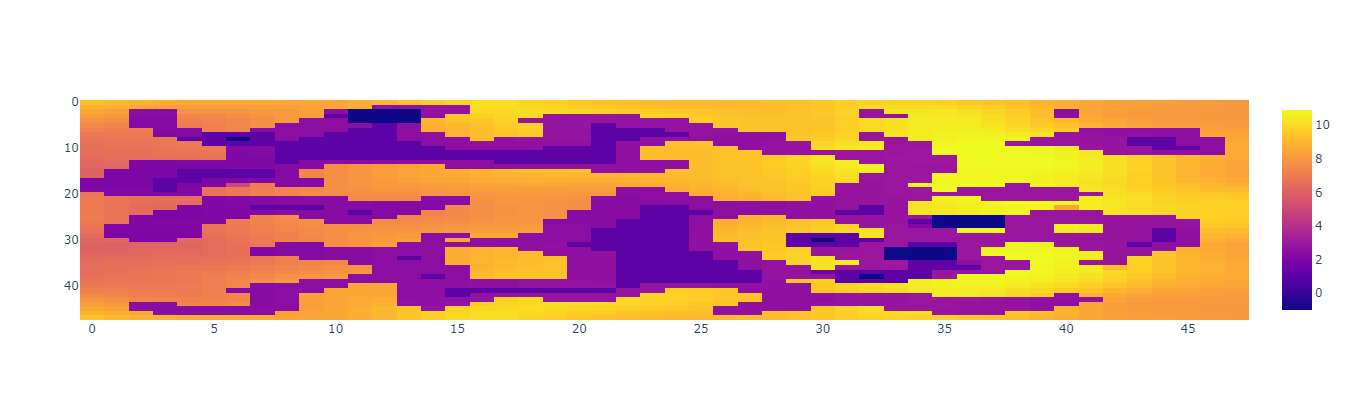

In [178]:
util.show_map_array(agent.master.pathfinder.full_costmap).update_layout(height=400, width=500)